<a href="https://colab.research.google.com/github/EstebanUOC/EstebanUOC/blob/main/lr_simulation_documented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline # A command that allows plots to be displayed inline within the notebook.
plt.rcParams['figure.figsize'] = [12, 9] # Sets the default size of the plots to 12x9 inches.
plt.rcParams['font.size'] = 14

In [ ]:
base_positive_lr = 3
base_negative_lr = -2
lr_delta = 0.5
max_lr = 10
optimal_v = 20

In [ ]:
soft_stops = [50*(2*i + 1) for i in range(20)]
hard_stops = [100*i for i in range(20)]
min_lr_for_soft_stops = 5

In [ ]:
def compute_next_lr(current_lr, rt_2, rt_1, rt, vt):
    if rt_2 == 0:
        if rt_1 == 0:
            if rt == 0:
                next_lr = current_lr - lr_delta
            else:
                next_lr = base_positive_lr
        else:
            if rt == 0:
                next_lr = base_positive_lr
            else:
                next_lr = current_lr + lr_delta * (optimal_v / vt)
    else:
        if rt_1 == 0:
            if rt == 0:
                next_lr = base_negative_lr
            else:
                next_lr = base_positive_lr
        else:
            if rt == 0:
                next_lr = base_positive_lr
            else:
                next_lr = current_lr + lr_delta * (optimal_v / vt)

    if next_lr > max_lr:
        next_lr = max_lr

    if next_lr < -1 * max_lr:
        next_lr = -1 * max_lr

    return next_lr

In [ ]:
def propose_next_exercise(current_exercise, lr):
    next_exercise = int(current_exercise + lr)

    # Soft stops
    for st in soft_stops:
        if current_exercise < st and next_exercise > st and lr < min_lr_for_soft_stops:
            next_exercise = st
            break

    # Hard stops
    for ht in hard_stops:
        if current_exercise < ht and next_exercise > ht:
            next_exercise = ht
            break

    return next_exercise

In [ ]:
n_exercises_per_student_simulation = 200
n_simulations = 1000

max_v = 300
v_sigma = 10

In [ ]:
def simulate_single_student(student_p, student_mu):
    current_exercise = 1
    current_lr = 1

    rt_2 = 1
    rt_1 = 1

    historic_lrs = [current_lr]
    historic_exercises = [current_exercise]
    for _ in range(n_exercises_per_student_simulation):
        rt = np.random.choice(2, p=[1 - student_p, student_p])
        vt = np.random.normal(loc=student_mu, scale=v_sigma)

        vt = np.clip(vt, optimal_v, max_v)

        next_lr = compute_next_lr(current_lr, rt_2, rt_1, rt, vt)
        current_lr = next_lr

        next_exercise = propose_next_exercise(current_exercise, current_lr)
        current_exercise = next_exercise

        rt_2 = rt_1
        rt_1 = rt

        historic_lrs.append(current_lr)
        historic_exercises.append(current_exercise)

    return historic_lrs, historic_exercises

In [ ]:
def simulate_student_type(student_p, student_mu):
    global_lr = np.zeros(shape=(n_simulations, n_exercises_per_student_simulation + 1))
    global_exercises = np.zeros(shape=(n_simulations, n_exercises_per_student_simulation + 1))
    global_stats = []
    for i in range(n_simulations):
        historic_lrs, historic_exercises = simulate_single_student(student_p, student_mu)
        stats = {}
        stats["min"] = np.min(historic_lrs)
        stats["mean"] = np.mean(historic_lrs)
        stats["max"] = np.max(historic_lrs)

        global_stats.append(stats)

        global_lr[i] = np.array(historic_lrs)
        global_exercises[i] = np.array(historic_exercises)

    stats_df = pd.DataFrame(global_stats)

    return stats_df, global_lr, global_exercises

In [ ]:
mediocre_student_p = 0.2
mediocre_student_mu = 100

bad_student_p = 0.5
bad_student_mu = 60

good_student_p = 0.8
good_student_mu = 30

excellent_student_p = 0.9
excellent_student_mu = 20

In [ ]:
mediocre_student_stats_df, mediocre_student_global_lr, mediocre_student_global_exercises = simulate_student_type(mediocre_student_p, mediocre_student_mu)
bad_student_stats_df, bad_student_global_lr, bad_student_global_exercises = simulate_student_type(bad_student_p, bad_student_mu)
good_student_stats_df, good_student_global_lr, good_student_global_exercises = simulate_student_type(good_student_p, good_student_mu)
excellent_student_stats_df, excellent_student_global_lr, excellent_student_global_exercises = simulate_student_type(excellent_student_p, excellent_student_mu)

In [ ]:
mediocre_student_stats_df.describe()

,min,mean,max
count,1000.000000,1000.000000,1000.000000
mean,-9.130500,-1.367824,3.207689
std,1.117349,0.561831,0.082696
min,-10.000000,-3.594549,3.090872
25%,-10.000000,-1.739275,3.125166
50%,-10.000000,-1.336626,3.204061
75%,-8.500000,-0.969812,3.229986
max,-5.000000,0.097320,3.613269


In [ ]:
bad_student_stats_df.describe()

,min,mean,max
count,1000.000000,1000.000000,1000.000000
mean,-4.457000,1.707898,4.049067
std,0.909108,0.257890,0.337889
min,-10.000000,0.759208,3.463548
25%,-5.000000,1.542743,3.835231
50%,-4.500000,1.727808,3.969853
75%,-4.000000,1.881330,4.206226
max,-2.500000,2.490996,6.287947


In [ ]:
good_student_stats_df.describe()

,min,mean,max
count,1000.000000,1000.000000,1000.000000
mean,-2.518500,3.818755,8.708841
std,0.438863,0.301481,1.090796
min,-4.000000,2.913725,5.697038
25%,-3.000000,3.612266,7.813569
50%,-2.500000,3.782714,8.749468
75%,-2.000000,3.983790,9.955986
max,1.000000,5.041616,10.000000


In [ ]:
excellent_student_stats_df.describe()

,min,mean,max
count,1000.000000,1000.000000,1000.000000
mean,-1.714000,5.656790,9.995657
std,1.041292,0.563629,0.056354
min,-3.000000,4.371133,8.927791
25%,-2.000000,5.256506,10.000000
50%,-2.000000,5.616045,10.000000
75%,-2.000000,5.995080,10.000000
max,1.000000,7.705148,10.000000


In [ ]:
mediocre_student_global_lr_mean = np.mean(mediocre_student_global_lr, axis=0)
mediocre_student_global_lr_std = np.std(mediocre_student_global_lr, axis=0)

bad_student_global_lr_mean = np.mean(bad_student_global_lr, axis=0)
bad_student_global_lr_std = np.std(bad_student_global_lr, axis=0)

good_student_global_lr_mean = np.mean(good_student_global_lr, axis=0)
good_student_global_lr_std = np.std(good_student_global_lr, axis=0)

excellent_student_global_lr_mean = np.mean(excellent_student_global_lr, axis=0)
excellent_student_global_lr_std = np.std(excellent_student_global_lr, axis=0)

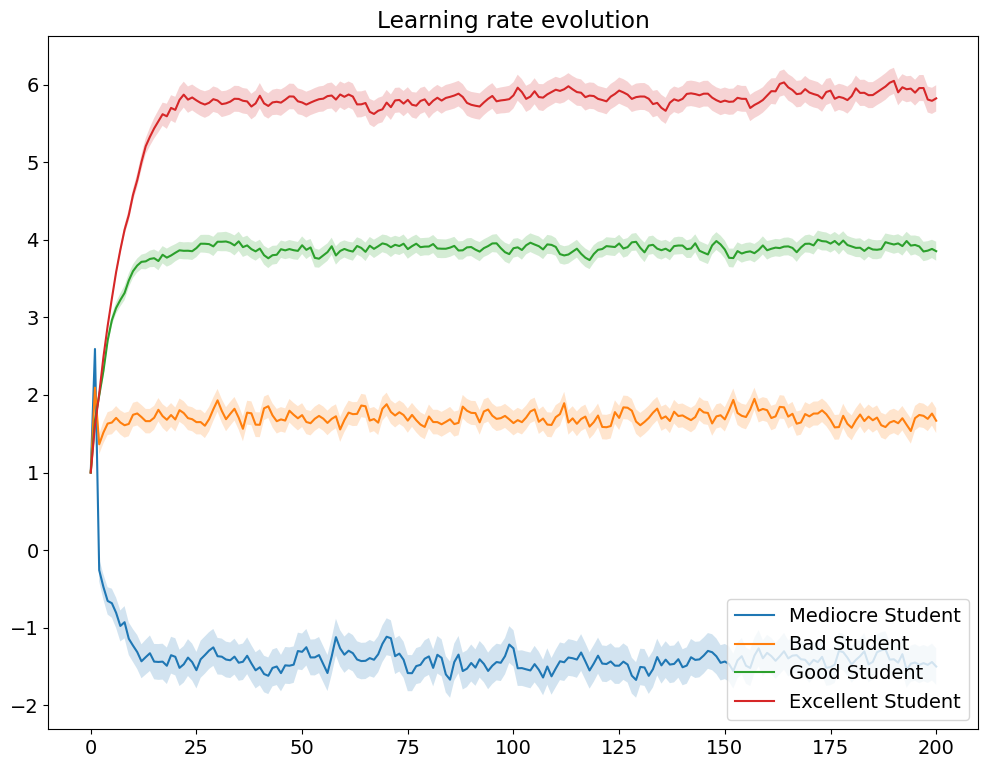

In [ ]:
plt.plot(range(n_exercises_per_student_simulation + 1), mediocre_student_global_lr_mean, label="Mediocre Student")
plt.fill_between(range(n_exercises_per_student_simulation + 1),
                 mediocre_student_global_lr_mean - 2*mediocre_student_global_lr_std / np.sqrt(n_simulations),
                 mediocre_student_global_lr_mean + 2*mediocre_student_global_lr_std / np.sqrt(n_simulations),
                 alpha=0.2)

plt.plot(range(n_exercises_per_student_simulation + 1), bad_student_global_lr_mean, label="Bad Student")
plt.fill_between(range(n_exercises_per_student_simulation + 1),
                 bad_student_global_lr_mean - 2*bad_student_global_lr_std / np.sqrt(n_simulations),
                 bad_student_global_lr_mean + 2*bad_student_global_lr_std / np.sqrt(n_simulations),
                 alpha=0.2)

plt.plot(range(n_exercises_per_student_simulation + 1), good_student_global_lr_mean, label="Good Student")
plt.fill_between(range(n_exercises_per_student_simulation + 1),
                 good_student_global_lr_mean - 2*good_student_global_lr_std / np.sqrt(n_simulations),
                 good_student_global_lr_mean + 2*good_student_global_lr_std / np.sqrt(n_simulations),
                 alpha=0.2)

plt.plot(range(n_exercises_per_student_simulation + 1), excellent_student_global_lr_mean, label="Excellent Student")
plt.fill_between(range(n_exercises_per_student_simulation + 1),
                 excellent_student_global_lr_mean - 2*excellent_student_global_lr_std / np.sqrt(n_simulations),
                 excellent_student_global_lr_mean + 2*excellent_student_global_lr_std / np.sqrt(n_simulations),
                 alpha=0.2)
plt.legend(loc="lower right")
plt.title("Learning rate evolution")
plt.show()

In [ ]:
mediocre_student_global_exercises_mean = np.mean(mediocre_student_global_exercises, axis=0)
mediocre_student_global_exercises_std = np.std(mediocre_student_global_exercises, axis=0)

bad_student_global_exercises_mean = np.mean(bad_student_global_exercises, axis=0)
bad_student_global_exercises_std = np.std(bad_student_global_exercises, axis=0)

good_student_global_exercises_mean = np.mean(good_student_global_exercises, axis=0)
good_student_global_exercises_std = np.std(good_student_global_exercises, axis=0)

excellent_student_global_exercises_mean = np.mean(excellent_student_global_exercises, axis=0)
excellent_student_global_exercises_std = np.std(excellent_student_global_exercises, axis=0)

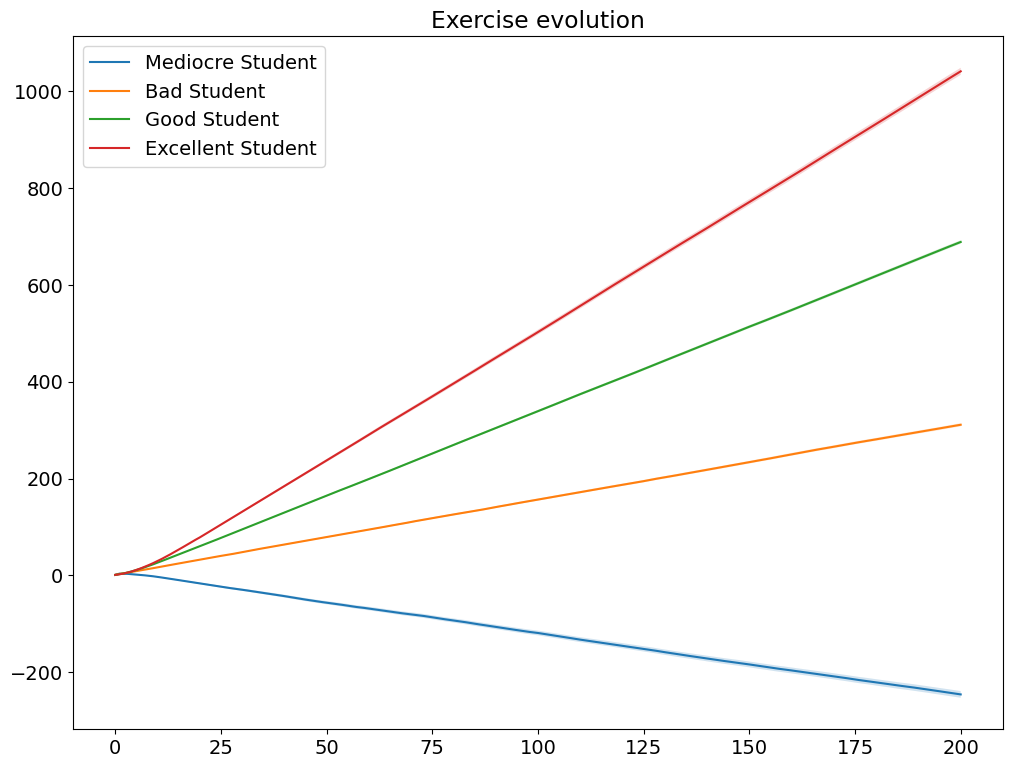

In [ ]:
plt.plot(range(n_exercises_per_student_simulation + 1), mediocre_student_global_exercises_mean, label="Mediocre Student")
plt.fill_between(range(n_exercises_per_student_simulation + 1),
                 mediocre_student_global_exercises_mean - 2*mediocre_student_global_exercises_std / np.sqrt(n_simulations),
                 mediocre_student_global_exercises_mean + 2*mediocre_student_global_exercises_std / np.sqrt(n_simulations),
                 alpha=0.2)

plt.plot(range(n_exercises_per_student_simulation + 1), bad_student_global_exercises_mean, label="Bad Student")
plt.fill_between(range(n_exercises_per_student_simulation + 1),
                 bad_student_global_exercises_mean - 2*bad_student_global_exercises_std / np.sqrt(n_simulations),
                 bad_student_global_exercises_mean + 2*bad_student_global_exercises_std / np.sqrt(n_simulations),
                 alpha=0.2)

plt.plot(range(n_exercises_per_student_simulation + 1), good_student_global_exercises_mean, label="Good Student")
plt.fill_between(range(n_exercises_per_student_simulation + 1),
                 good_student_global_exercises_mean - 2*good_student_global_exercises_std / np.sqrt(n_simulations),
                 good_student_global_exercises_mean + 2*good_student_global_exercises_std / np.sqrt(n_simulations),
                 alpha=0.2)

plt.plot(range(n_exercises_per_student_simulation + 1), excellent_student_global_exercises_mean, label="Excellent Student")
plt.fill_between(range(n_exercises_per_student_simulation + 1),
                 excellent_student_global_exercises_mean - 2*excellent_student_global_exercises_std / np.sqrt(n_simulations),
                 excellent_student_global_exercises_mean + 2*excellent_student_global_exercises_std / np.sqrt(n_simulations),
                 alpha=0.2)
plt.legend()
plt.title("Exercise evolution")
plt.show()

In [ ]:
mediocre_c = Counter([x for w in mediocre_student_global_exercises.tolist() for x in w])
bad_c = Counter([x for w in bad_student_global_exercises.tolist() for x in w])
good_c = Counter([x for w in good_student_global_exercises.tolist() for x in w])
excellent_c = Counter([x for w in excellent_student_global_exercises.tolist() for x in w])
global_c = mediocre_c + bad_c + good_c + excellent_c
max_exercise = int(max(global_c))
counts = [global_c[i] for i in range(max_exercise)]

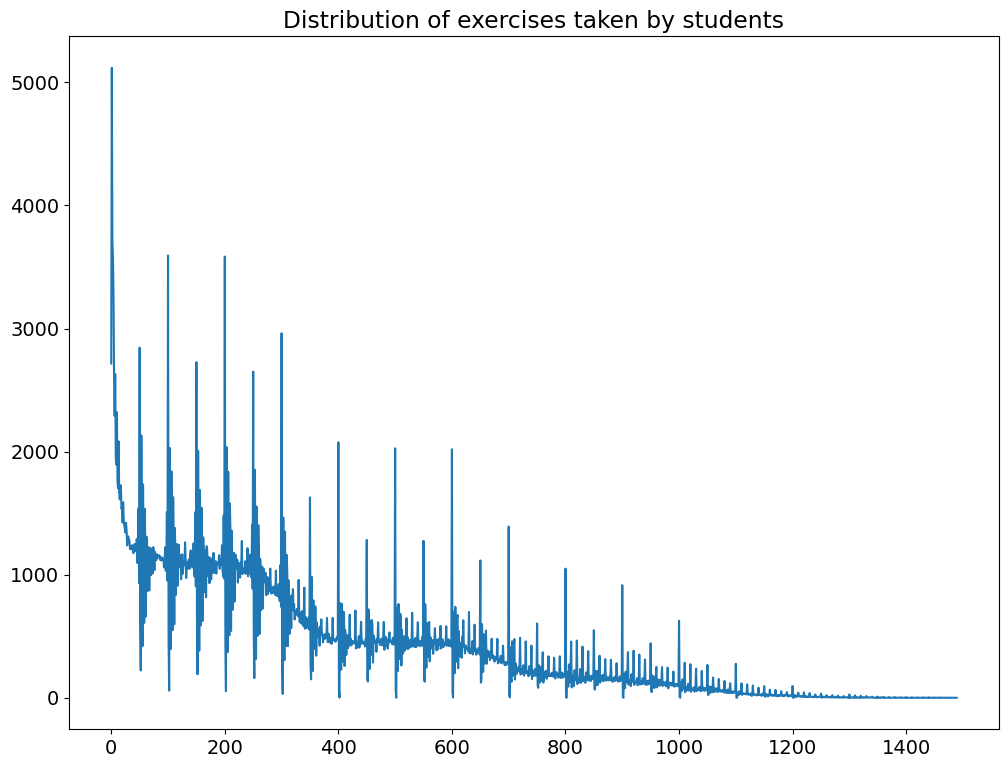

In [ ]:
plt.plot(range(max_exercise), counts)
plt.title("Distribution of exercises taken by students")
plt.show()